### Creating data

In [1]:
import sys
import os
current = os.path.dirname(os.path.realpath('./'))
sys.path.append(current)
from utils.ld_tools import *
from sklearn import datasets
import matplotlib.pyplot as plt

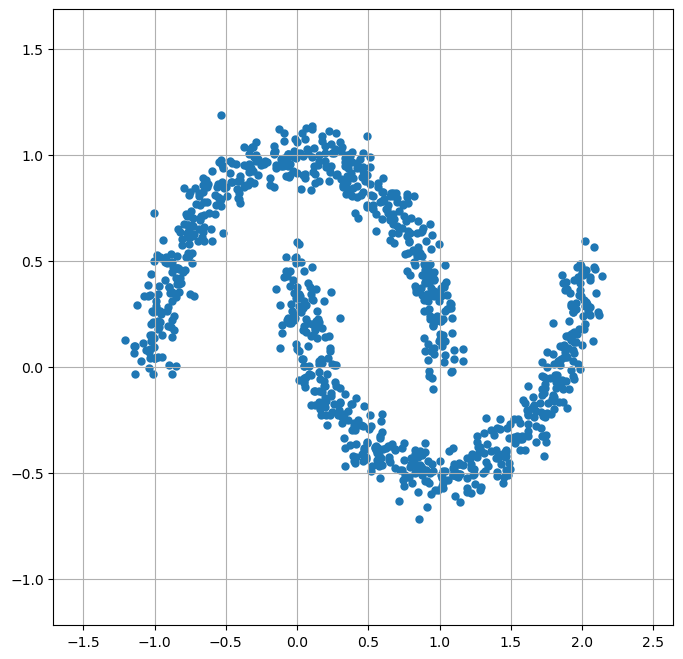

In [2]:
X, y = datasets.make_moons(n_samples=1000,noise=0.07,random_state=1)
plt.rcParams['figure.figsize'] = [8,8]
plt.scatter(X[:,0],X[:,1],linewidths=0.01)
plt.grid()
plt.xlim(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5)
plt.ylim(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5)
plt.show()

In [3]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, list_input, list_target, transform=None, target_transform=None):
        self.list_input = list_input
        self.list_target = list_target
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.list_input)

    def __getitem__(self, idx):
        input = self.list_input[idx]
        target = self.list_target[idx]
        if self.transform:
            input = self.transform(input)
        if self.target_transform:
            target = self.transform(target)
        return input, target

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,random_split
import torch
X_tensor = torch.tensor(X,dtype=torch.float32)
train_dataset = CustomDataset(X_tensor,y)

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), m-int(m-m*0.2)])

batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_data

### Define model

In [5]:
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(2, 20),
            nn.ReLU(),
            nn.Linear(20,20),
            )
        self.last_layer = nn.Linear(20,2)

    def forward_before_softmax(self, x):
        x = self.classifier(x)
        return x

    def forward(self, x):
        x = self.forward_before_softmax(x)
        x = self.last_layer(x)
        return x

model = Net()
print(model)

Net(
  (classifier): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
  )
  (last_layer): Linear(in_features=20, out_features=2, bias=True)
)


### Defining Training Loop

In [6]:
def train(dataloader, model, loss_fn, optimizer,device='cpu'):

    # Total size of dataset for reference
    size = 0

    # places your model into training mode
    model.train()

    # loss batch
    batch_loss = {}
    batch_accuracy = {}

    correct = 0
    _correct = 0



    # Gives X , y for each batch
    for batch, (X, y) in enumerate(dataloader):

        # Converting device to cuda
        X, y = X.to(device), y.to(device)
        model.to(device)

        # Compute prediction error / loss
        # 1. Compute y_pred
        # 2. Compute loss between y and y_pred using selectd loss function

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # Backpropagation on optimizing for loss
        # 1. Sets gradients as 0
        # 2. Compute the gradients using back_prop
        # 3. update the parameters using the gradients from step 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
        _batch_size = len(X)

        correct += _correct

        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.item()
        batch_accuracy[batch] = _correct/_batch_size

        size += _batch_size

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}]")

    correct/=size
    print(f"Train Accuracy: {(100*correct):>0.1f}%")

    return batch_loss , batch_accuracy

### Defining valid/test loop

Validation loop is same as train loop ignoring the updates from back propagation . Hence we need to set the model under evaluation mode to avoid any parameters update . We then calculate the loss and accuracy in the same way we did inside the training loop

In [7]:
def validation(dataloader, model, loss_fn,device='cpu'):

    # Total size of dataset for reference
    size = 0
    num_batches = len(dataloader)

    # Setting the model under evaluation mode.
    model.eval()

    test_loss, correct = 0, 0

    _correct = 0
    _batch_size = 0

    batch_loss = {}
    batch_accuracy = {}

    with torch.no_grad():

        # Gives X , y for each batch
        for batch , (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            model.to(device)
            pred = model(X)
            batch_loss[batch] = loss_fn(pred, y).item()
            test_loss += batch_loss[batch]
            _batch_size = len(X)

            _correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += _correct

            size+=_batch_size
            batch_accuracy[batch] = _correct/_batch_size




    ## Calculating loss based on loss function defined
    test_loss /= num_batches

    ## Calculating Accuracy based on how many y match with y_pred
    correct /= size

    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return batch_loss , batch_accuracy

### Training and validation triggers

This step is mainly for defining the epochs (The number of passes that needs to be done on the entire dataset) while measuring the model performance .

In [8]:
model = Net()
print(model)

Net(
  (classifier): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
  )
  (last_layer): Linear(in_features=20, out_features=2, bias=True)
)


In [9]:
## Defining optimizer and loss functions

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_batch_loss = []
train_batch_accuracy = []
valid_batch_accuracy = []
valid_batch_loss = []
train_epoch_no = []
valid_epoch_no = []

epochs = 160
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    _train_batch_loss , _train_batch_accuracy = train(train_loader, model, loss_fn, optimizer)
    _valid_batch_loss , _valid_batch_accuracy = validation(valid_loader, model, loss_fn)
    for i in range(len(_train_batch_loss)):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append( t + float((i+1)/len(_train_batch_loss)))
    for i in range(len(_valid_batch_loss)):
        valid_batch_loss.append(_valid_batch_loss[i])
        valid_batch_accuracy.append(_valid_batch_accuracy[i])
        valid_epoch_no.append( t + float((i+1)/len(_valid_batch_loss)))
a=print("Done!")

Epoch 1
-------------------------------
loss: 0.732439  [    0]
Train Accuracy: 30.5%
Valid Error: 
 Accuracy: 43.0%, Avg loss: 0.694201 

Epoch 2
-------------------------------
loss: 0.692227  [    0]
Train Accuracy: 61.9%
Valid Error: 
 Accuracy: 75.5%, Avg loss: 0.662947 

Epoch 3
-------------------------------
loss: 0.656279  [    0]
Train Accuracy: 79.8%
Valid Error: 
 Accuracy: 78.5%, Avg loss: 0.633084 

Epoch 4
-------------------------------
loss: 0.622359  [    0]
Train Accuracy: 80.4%
Valid Error: 
 Accuracy: 78.5%, Avg loss: 0.603633 

Epoch 5
-------------------------------
loss: 0.589210  [    0]
Train Accuracy: 79.2%
Valid Error: 
 Accuracy: 78.0%, Avg loss: 0.574097 

Epoch 6
-------------------------------
loss: 0.556159  [    0]
Train Accuracy: 79.0%
Valid Error: 
 Accuracy: 79.0%, Avg loss: 0.544316 

Epoch 7
-------------------------------
loss: 0.523065  [    0]
Train Accuracy: 79.8%
Valid Error: 
 Accuracy: 79.5%, Avg loss: 0.514504 

Epoch 8
-------------------

Train Accuracy: 99.6%
Valid Error: 
 Accuracy: 100.0%, Avg loss: 0.024939 

Epoch 90
-------------------------------
loss: 0.027756  [    0]
Train Accuracy: 99.8%
Valid Error: 
 Accuracy: 100.0%, Avg loss: 0.024051 

Epoch 91
-------------------------------
loss: 0.026803  [    0]
Train Accuracy: 99.8%
Valid Error: 
 Accuracy: 100.0%, Avg loss: 0.023193 

Epoch 92
-------------------------------
loss: 0.025893  [    0]
Train Accuracy: 99.8%
Valid Error: 
 Accuracy: 100.0%, Avg loss: 0.022403 

Epoch 93
-------------------------------
loss: 0.025048  [    0]
Train Accuracy: 99.9%
Valid Error: 
 Accuracy: 100.0%, Avg loss: 0.021663 

Epoch 94
-------------------------------
loss: 0.024258  [    0]
Train Accuracy: 99.9%
Valid Error: 
 Accuracy: 100.0%, Avg loss: 0.020950 

Epoch 95
-------------------------------
loss: 0.023505  [    0]
Train Accuracy: 99.9%
Valid Error: 
 Accuracy: 100.0%, Avg loss: 0.020257 

Epoch 96
-------------------------------
loss: 0.022776  [    0]
Train Accurac

In [10]:
### Defining grid of points to evaluate

In [11]:
import numpy as np
# define the lower and upper limits for x and y
minX1, maxX1, minX2, maxX2 = np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, np.min(X[:,1])-0.5, np.max(X[:,1])+0.5
# create one-dimensional arrays for x and y
x1 = np.linspace(minX1, maxX1, 30)
x2 = np.linspace(minX2, maxX2, 30)
# create the mesh based on these arrays
X1, X2 = np.meshgrid(x1, x2)
X1 = X1.reshape(-1,)
X2 = X2.reshape(-1,)
X_ext = np.zeros((len(X1),2))
X_ext[:,0] = X1
X_ext[:,1] = X2

#### Predictive entropy

/tmp/ipykernel_3058495/1474659213.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(X[np.where(y==0)][:,0], X[np.where(y==0)][:,1], 'ko', ms=3,color='yellow')
/tmp/ipykernel_3058495/1474659213.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(X[np.where(y==1)][:,0], X[np.where(y==1)][:,1], 'ko', ms=3,color='black')


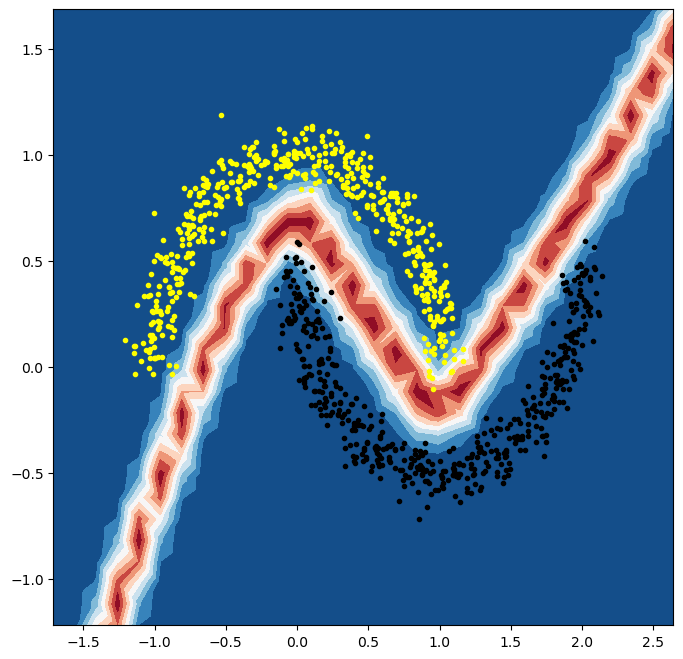

In [12]:
with torch.no_grad():
    y_predic_ext = model(torch.tensor(X_ext,dtype=torch.float32))
    y_predic_ext = torch.nn.functional.softmax(y_predic_ext, dim=1).clone().detach().cpu().numpy()
import scipy
entropy = scipy.stats.entropy(y_predic_ext,axis=1)
plt.rcParams["figure.figsize"] = (8,8)
fig, ax = plt.subplots()
cntr = ax.tricontourf(X_ext[:,0],X_ext[:,1], entropy, levels=10, cmap="RdBu_r")  #"coolwarm"
#fig.colorbar(cntr, ax=ax)
#ax.plot(X_ext[:,0], X_ext[:,1], 'o', ms=1, color="white")
#ax.plot(X[:,0], X[:,1], 'ko', ms=3)

ax.plot(X[np.where(y==0)][:,0], X[np.where(y==0)][:,1], 'ko', ms=3,color='yellow')
ax.plot(X[np.where(y==1)][:,0], X[np.where(y==1)][:,1], 'ko', ms=3,color='black')

ax.set(xlim=(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5), ylim=(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5))

plt.show()

### Euclidean distance

In [13]:
mean = []
for i in range(2):
    X_i = X_tensor[np.where(y==i)]
    mean_i = np.mean(model.forward_before_softmax(X_i).detach().numpy(),axis=0)
    print(mean_i.shape)
    mean += [mean_i]

(20,)
(20,)


/tmp/ipykernel_3058495/1828930986.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(X[np.where(y==0)][:,0], X[np.where(y==0)][:,1], 'ko', ms=3,color='yellow')
/tmp/ipykernel_3058495/1828930986.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(X[np.where(y==1)][:,0], X[np.where(y==1)][:,1], 'ko', ms=3,color='black')


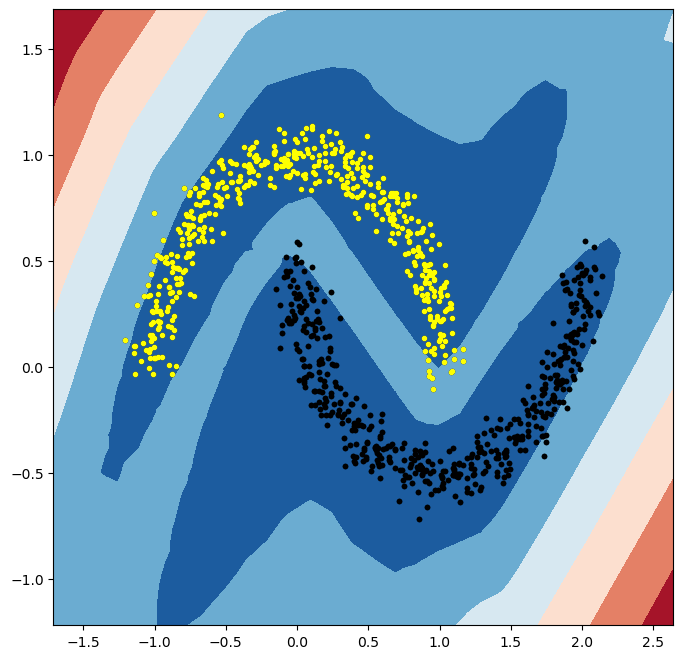

In [14]:
from scipy.spatial import  distance_matrix
feature_test = model.forward_before_softmax(torch.tensor(X_ext,dtype=torch.float32)).detach().numpy()
d_0 = distance_matrix(feature_test,mean[0].reshape(1,-1))
d_1 = distance_matrix(feature_test,mean[1].reshape(1,-1))
d = np.zeros((2,d_0.shape[0]))
d[0] = d_0.reshape(-1,)
d[1] = d_1.reshape(-1,)
import scipy
d_min = np.min(d,axis=0)
plt.rcParams["figure.figsize"] = (8,8)
fig, ax = plt.subplots()
cntr = ax.tricontourf(X_ext[:,0],X_ext[:,1], d_min, levels=5, cmap="RdBu_r")
#fig.colorbar(cntr, ax=ax)
#ax.plot(X_ext[:,0], X_ext[:,1], 'o', ms=1, color="white")
ax.plot(X[:,0], X[:,1], 'ko', ms=3)
#ax.set(xlim=(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5), ylim=(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5))
ax.plot(X[np.where(y==0)][:,0], X[np.where(y==0)][:,1], 'ko', ms=3,color='yellow')
ax.plot(X[np.where(y==1)][:,0], X[np.where(y==1)][:,1], 'ko', ms=3,color='black')

plt.show()

### Lens Depth

In [15]:
feature = []
for i in range(2):
    X_i = X_tensor[np.where(y==i)]
    feature_i = model.forward_before_softmax(X_i).detach().numpy()
    feature += [feature_i]
feature = np.array(feature)
feature.shape

(2, 500, 20)

In [16]:
feature_test = model.forward_before_softmax(torch.tensor(X_ext,dtype=torch.float32)).detach().numpy()
feature_test.shape

(900, 20)

In [17]:
from datetime import datetime
now = datetime.now()
LD = []
alpha = 15
for k in range(2):
    dist_mat = distance_matrix(feature[k],feature[k])
    fermat_dist_mat = fermat_function(dist_mat,alpha=alpha)
    lens_depth_ext_fermat = []
    for i in range(feature_test.shape[0]):
        dist_array = distance_matrix(feature[k],feature_test[i].reshape((1,-1)))
        dist_ext = fermat_function_ext(fermat_dist_mat, dist_array,alpha=alpha)
        lens_depth_ext_fermat += [lens_depth_ext_function(fermat_dist_mat, dist_ext)]
    LD += [np.array(lens_depth_ext_fermat)]
print("Time taken:", datetime.now()-now)
LD_max = np.max(LD,axis=0)
print(LD_max.shape)

Time taken: 0:00:05.307101
(900,)


/tmp/ipykernel_3058495/2678900449.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(X[np.where(y==0)][:,0], X[np.where(y==0)][:,1], 'ko', ms=3,color='yellow')
/tmp/ipykernel_3058495/2678900449.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(X[np.where(y==1)][:,0], X[np.where(y==1)][:,1], 'ko', ms=3,color='black')


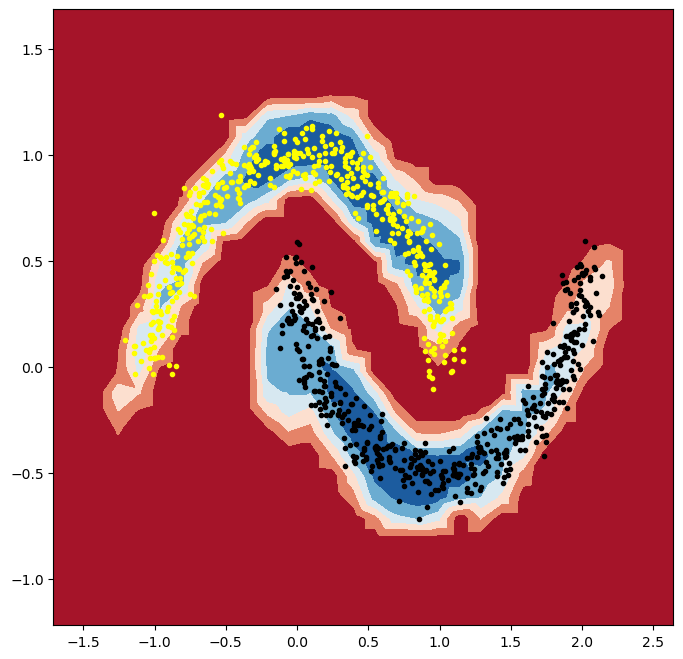

In [18]:
import scipy
plt.rcParams["figure.figsize"] = (8,8)
fig, ax = plt.subplots()
#cntr = ax.tricontourf(X_ext[:,0],X_ext[:,1], LD_max, levels=6, cmap="RdBu_r")
cntr = ax.tricontourf(X_ext[:,0],X_ext[:,1], np.max(LD_max)-LD_max, levels=6, cmap="RdBu_r")

ax.plot(X[np.where(y==0)][:,0], X[np.where(y==0)][:,1], 'ko', ms=3,color='yellow')
ax.plot(X[np.where(y==1)][:,0], X[np.where(y==1)][:,1], 'ko', ms=3,color='black')

ax.set(xlim=(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5), ylim=(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5))

plt.show()

In [19]:
np.min(LD_max),np.max(LD_max)

(0.0, 0.8462444889779559)